# 10/15/24: encoding phase plots
* As a reminder, 16 subjs across 29 session undergo watched an ~8 min film.
 
After wrangling all their data into 1 df, I plotted:  
1. Distribution of RTs
2. Rasters & PSTHs for example cells from each region. For the latter, I trimmed all trials to 5s.  
3. Distribution of avg FRs across trials (non-zero FRs only)
4. Trial-avged FR for correct vs incorrect (note that these are imbalanced classes as printed above the plot)
5. Trial-avged FR for (correct+high confidence) vs others (much better balanced)


In [34]:
import warnings
warnings.filterwarnings("ignore")

import os, pandas as pd, matplotlib.pyplot as plt, numpy as np, seaborn as sns, scipy.stats as stats, glob
from pynwb import NWBHDF5IO
from pathlib import Path
from convnwb.io import load_nwbfile

df = pd.read_pickle('neuron_by_trial_df.pkl')
df_encoding = df[df['stim_phase'] == 'encoding']
df_encoding = df_encoding[df_encoding['FR'] != 0]
df_encoding.head()

,subj,sess,neuron,region,start_time,stop_time,RT,trial_spikes,trial_aligned_spikes,num_spikes,FR,trial_smooth_spikes,trial_smooth_FR,stim_phase,stimulus_file,response_correct,response_confidence,actual_response
0,P41,P41CS_R1,P41CS_R1_21_1_679_4,amygdala,0.0,478.85512,478.85512,"[3.43207675, 4.39507675, 5.16801325, 5.2624507...","[3.43207675, 4.39507675, 5.16801325, 5.2624507...",360,0.751793,"[10, 12, 5, 5, 8, 7, 6, 7, 6, 2, 2, 2, 1, 5, 5...",7.557895,encoding,bd_movie,NaN,NaN,NaN
41,P41,P41CS_R1,P41CS_R1_38_1_613_5,ACC,0.0,478.85512,478.85512,"[0.2510465, 2.07970175, 4.70126325, 5.09220075...","[0.2510465, 2.07970175, 4.70126325, 5.09220075...",278,0.580551,"[5, 5, 3, 2, 3, 7, 10, 6, 7, 13, 9, 2, 4, 7, 7...",5.800000,encoding,bd_movie,NaN,NaN,NaN
82,P41,P41CS_R1,P41CS_R1_39_1_1359_5,ACC,0.0,478.85512,478.85512,"[0.3880465, 1.5347965, 1.61257775, 2.0414215, ...","[0.3880465, 1.5347965, 1.61257775, 2.0414215, ...",949,1.981810,"[9, 15, 18, 17, 17, 12, 10, 20, 34, 31, 18, 10...",19.831579,encoding,bd_movie,NaN,NaN,NaN
123,P41,P41CS_R1,P41CS_R1_40_1_2816_5,ACC,0.0,478.85512,478.85512,"[0.0642965, 0.80051525, 0.813359, 0.89145275, ...","[0.0642965, 0.80051525, 0.813359, 0.89145275, ...",1820,3.800732,"[29, 24, 34, 43, 32, 39, 43, 40, 33, 31, 43, 4...",38.084211,encoding,bd_movie,NaN,NaN,NaN
164,P41,P41CS_R1,P41CS_R1_40_2_2821_5,ACC,0.0,478.85512,478.85512,"[0.4351715, 0.88882775, 1.79107775, 3.7156705,...","[0.4351715, 0.88882775, 1.79107775, 3.7156705,...",379,0.791471,"[11, 10, 8, 8, 8, 8, 4, 9, 11, 9, 13, 8, 3, 4,...",7.936842,encoding,bd_movie,NaN,NaN,NaN


### confirm number of subjects, neurons, trials

In [35]:
len_df = len(df_encoding)
num_neurons = len(np.unique(df_encoding['neuron']))
num_subjs = len(np.unique(df_encoding['subj']))
num_sess = len(np.unique(df_encoding['sess']))
print(f'len_df = {len_df}, neurons {num_neurons}, subjects {num_subjs}, sessions {num_sess}')


len_df = 1450, neurons 1450, subjects 16, sessions 29


### example cell raster & PSTH by region

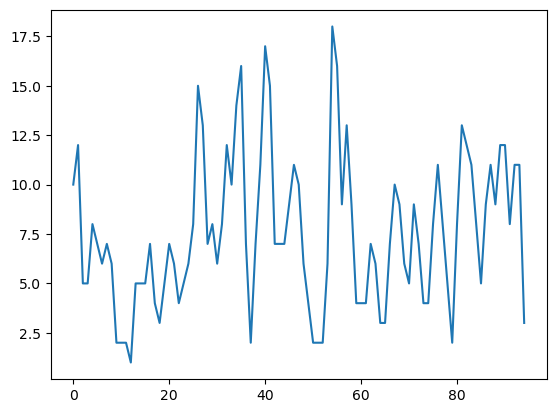

In [36]:
plt.plot(df_encoding['trial_smooth_spikes'][0])
plt.show()

In [ ]:
for region, region_df in df_recognition.groupby('region'):

    neuron_num = 0

    fig, ax = plt.subplots(1, 2, figsize=(10, 6))
    fig.suptitle(region)

    for neuron, neuron_df in region_df.groupby('neuron'):

        neuron_num+=1
        if neuron_num == 1:

            ax[0].eventplot(neuron_df['trial_aligned_spikes'], linelengths=0.8, color='black')
            ax[1].plot(np.mean(neuron_df['trial_smooth_spikes'], axis=0), color='black')

            break

    plt.tight_layout()
    plt.show()  


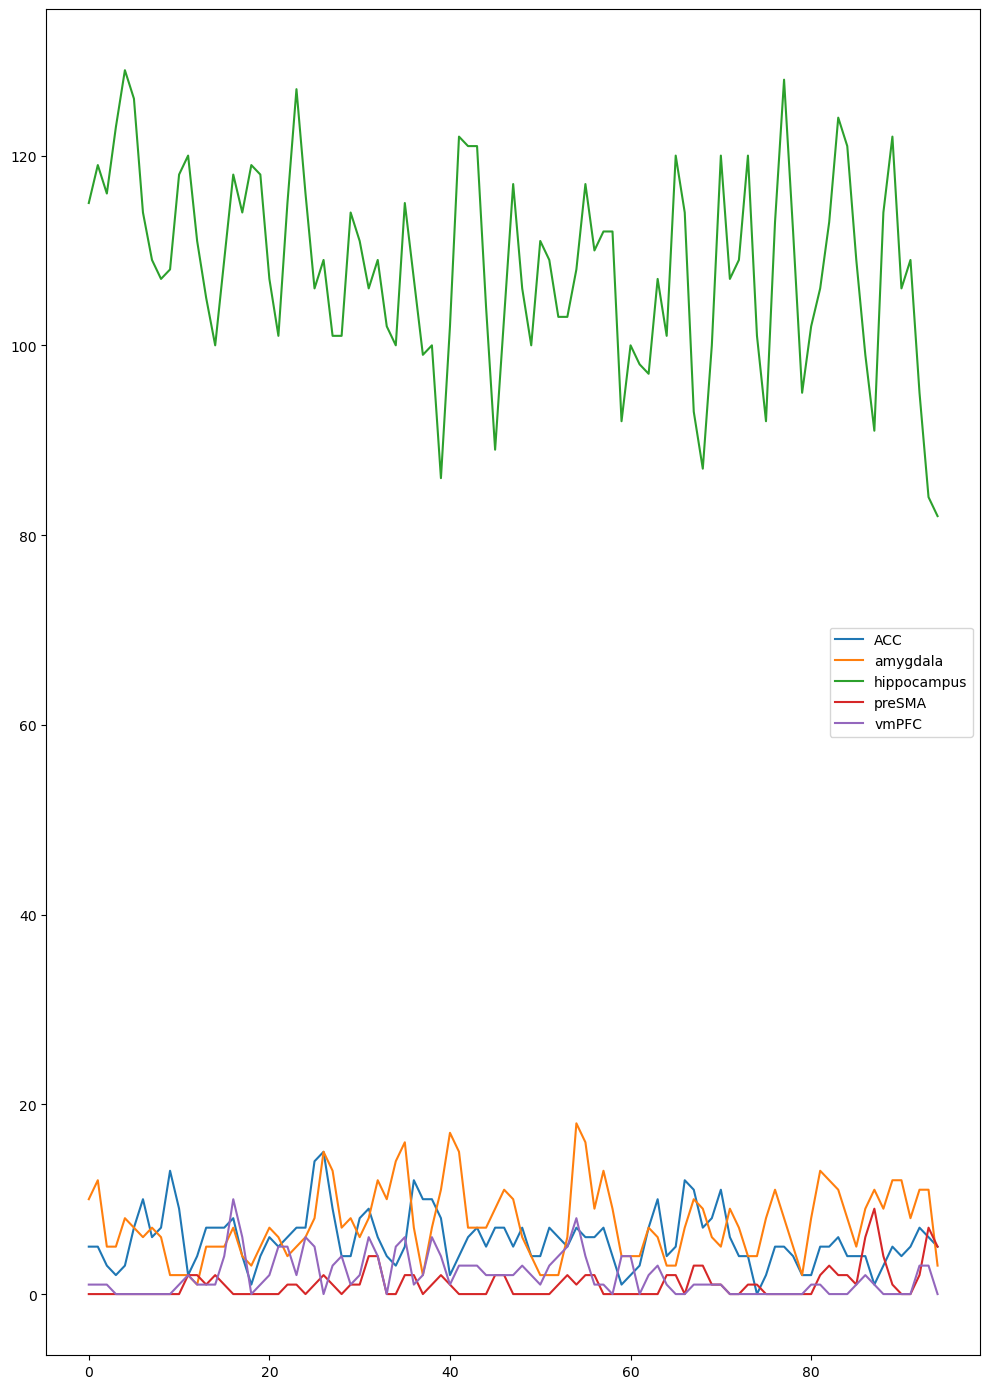

In [74]:
plt.figure(figsize=(10, 14))

for region, region_df in df_encoding.groupby('region'):

    for neuron, neuron_df in region_df.groupby('neuron'):
        
        plt.plot(neuron_df['trial_smooth_spikes'].tolist()[0], label=region)
        break

plt.legend()
plt.tight_layout()
plt.show()  


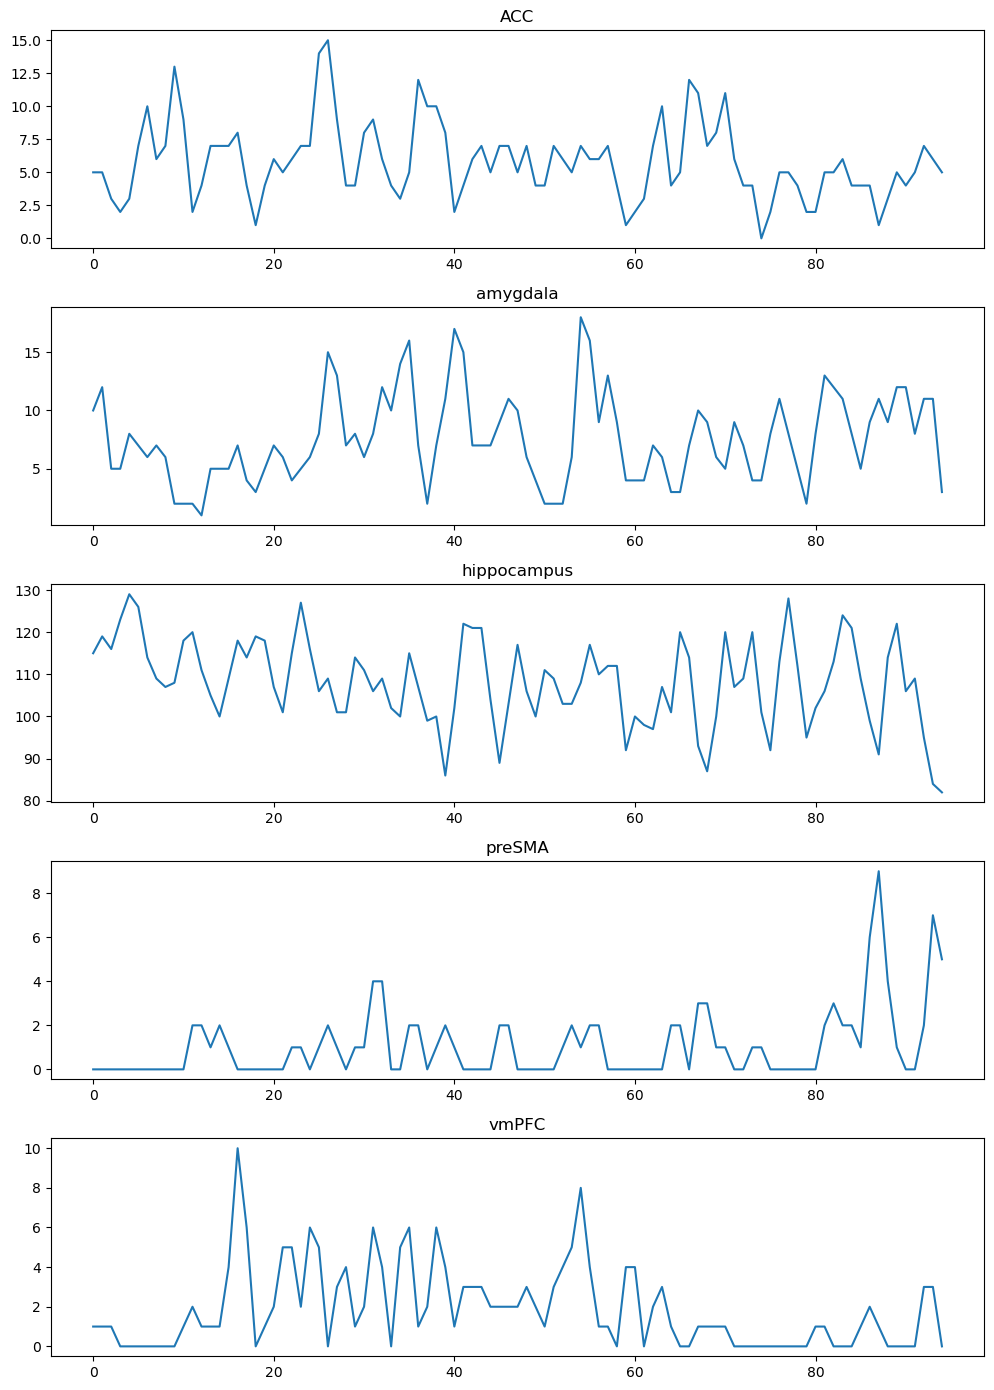

In [70]:
fig, axs = plt.subplots(5, 1, figsize=(10, 14))
i = 0

for region, region_df in df_encoding.groupby('region'):

    for neuron, neuron_df in region_df.groupby('neuron'):
        
        axs[i].plot(neuron_df['trial_smooth_spikes'].tolist()[0])
        axs[i].set_title(region)
        i+=1
        break

plt.tight_layout()
plt.show()  


### discard outliers with extreme FRs

48378


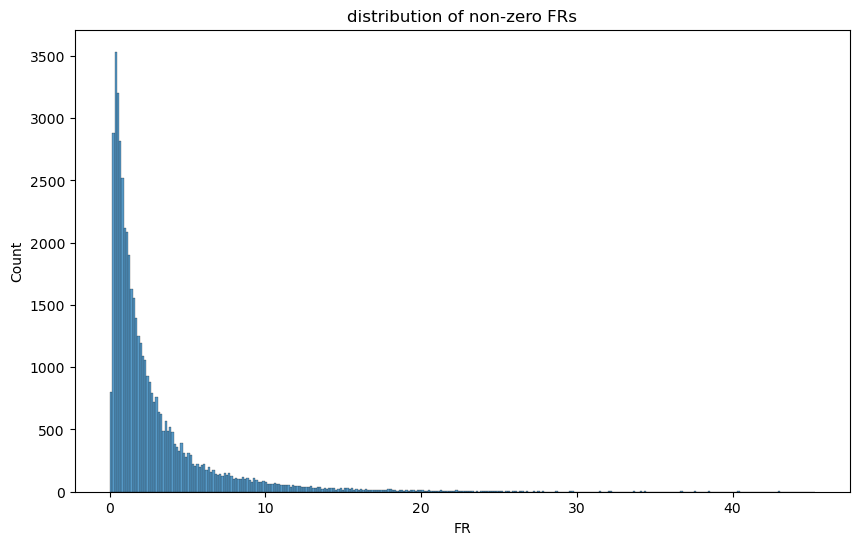

In [14]:
print(len(df_recognition))

# z_scores = stats.zscore(df_recognition['FR'])
# mask = (z_scores < 2) & (z_scores > -2)
# df_recognition = df_recognition[mask]

# print(f'num_trials after outlier removal: {len(df_recognition)}')

plt.figure(figsize=(10,6))
sns.histplot(df_recognition['FR'])
plt.title('distribution of non-zero FRs')
plt.show()

### trial-avged FRs by correctness

region       response_correct
ACC          0.0                  2460
             1.0                  5226
amygdala     0.0                  3461
             1.0                 12290
hippocampus  0.0                  2139
             1.0                  6640
preSMA       0.0                  2482
             1.0                  7797
vmPFC        0.0                  1317
             1.0                  4566
dtype: int64


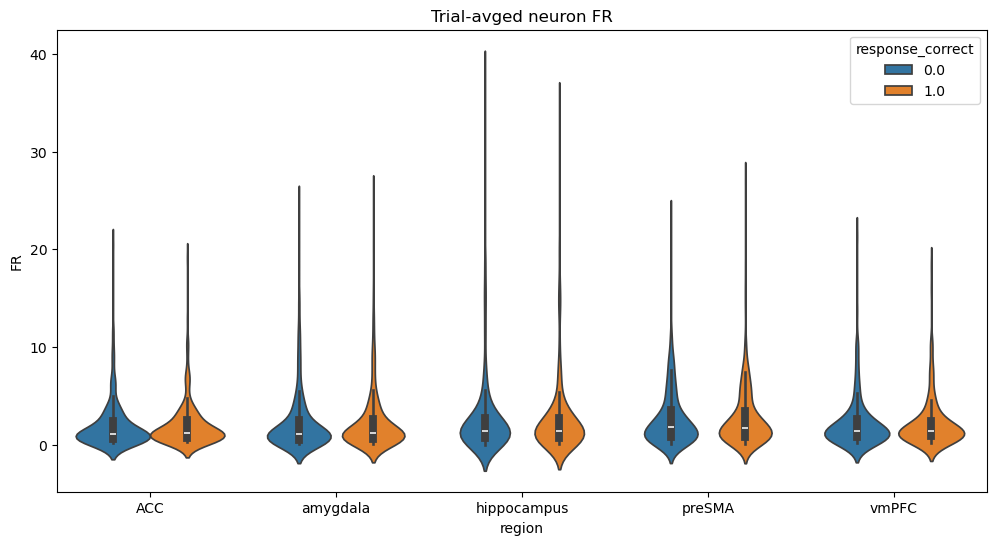

In [6]:
print(df_recognition.groupby(['region', 'response_correct']).size())

trial_avg_fr = df_recognition.groupby(['region', 'neuron', 'response_correct'])['FR'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.violinplot(data=trial_avg_fr, x='region', y='FR', hue='response_correct')
plt.title('Trial-avged neuron FR')
plt.show()


### trial-avged FR by confidence+correctness

region       conf_corr          
ACC          Confident & Correct    3673
             Other                  4013
amygdala     Confident & Correct    8040
             Other                  7711
hippocampus  Confident & Correct    4498
             Other                  4281
preSMA       Confident & Correct    5314
             Other                  4965
vmPFC        Confident & Correct    3044
             Other                  2839
dtype: int64


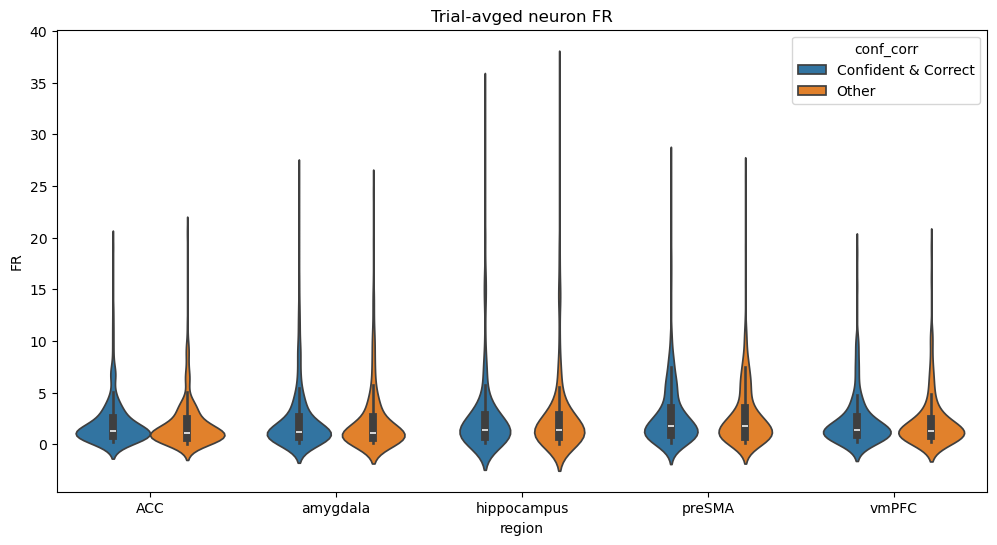

In [7]:
df_recognition['conf_corr'] = df_recognition.apply(lambda row: 'Confident & Correct' if row['response_confidence'] == 3 and row['response_correct'] == 1 else 'Other', axis=1)
print(df_recognition.groupby(['region', 'conf_corr']).size())

trial_avg_fr = df_recognition.groupby(['region', 'neuron', 'conf_corr'])['FR'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.violinplot(data=trial_avg_fr, x='region', y='FR', hue='conf_corr')
plt.title('Trial-avged neuron FR')
plt.show()
